In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import pdb

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## What this notebook contains

The goal of this notebook is to set-up one of the key experiments contained in my paper. The overall idea is that even when the ground-truth data is generated as a linear regression, the alternating minimization-grad descent scheme is very suboptimal, even when you overparameterize the representation as a powerful neural network (compared to the ground truth representation, which is just a matrix in this case).

To put some math into this, we assume that our data is generated as:
\begin{align*}
    y^{(t)}_i = F^{(t)}_\star \Phi_\star x^{(t)}_i + w^{(t)}_i,\quad y^{(t)}_i \in \mathbb R^{d_y}, x^{(t)}_i \in \mathbb R^{d_x}, \Phi_\star \in \mathbb R^{r \times d_x}.
\end{align*}
where $t$ indexes distinct tasks $t = 1,\dots, T$. For normalization purposes, we assume $\Phi_\star$ has orthonormal rows. In this set of experiments, we simplify things and assume $x^{(t)}_i$ and $w^{(t)}_i$ are independent and identically distributed across all tasks:
\begin{align*}
    x_i^{(t)} \sim \mathcal N (0, \Sigma_x),\;\; w_i^{(t)} \sim \mathcal N(0, \sigma^2 \cdot \mathrm{Id}), \quad \text{for all }i,t.
\end{align*}
Notably, $\Sigma_x \succ 0$ is going to be generated as some covariance matrix that is *non-isotropic*, i.e. not Identity (or any constant scaling of it. We can take a peek at the data generation functions we imported: `from linreg_data import generate_parameters, generate_data`.

In [2]:
def generate_parameters(dx, dy, r, num_tasks):

    # randomly generate covariance of x
    U = 5*torch.eye(dx) + torch.randn(dx, dx)
    Sigma_x = 0.5*(U + U.T)                                # Make Sigma_x symmetric
    Sigma_x = (dx / torch.trace(Sigma_x)) * Sigma_x        # normalize to get Tr(Sigma_x) = dx

    # randomly generate representation Phi*
    A = torch.randn(r, dx)
    _, _, Phi = torch.linalg.svd(A, full_matrices = False) # Generate Phi* as random matrix that is then orthonormalized.

    # randomly generate heads F0 (for validation), F1,...,FT (for training)
    F0 = torch.randn(dy, r)
    Fs = []
    Fs.append(F0)
    for i in range(num_tasks):
        gamma = 0.01
        B = torch.randn(dy, dy)
        rot = torch.linalg.matrix_exp(0.5*gamma*(B - B.T)) # Generate heads by randomly applying a rotation to F0
        F = rot @ F0
        Fs.append(F)

    return Fs, Phi, Sigma_x

As one can glean above, the `generate_parameters` is an exceedingly simple way to randomly generate the key parameters of the ground-truth data, which are the heads $F^{(1)},\dots, F^{(T)}$, the representation $\Phi_\star$ and the *non-isotropic* data covariance $\Sigma_x$.

The following function `generate_data` simply generates data $(x^{(t)}_i, y_i^{(t)})$ from said parameters.

In [3]:
# def generate_data(n_points, Fs, Phi, cov_x, mode = 'train'):

#     U, S, V = torch.linalg.svd(cov_x)
#     cov_x_sqrt = U @ torch.diag(torch.sqrt(S)) @ V
#     dy = Fs[0].shape[0]
#     dx = Phi.shape[-1]

#     if mode == 'train':
#         X = []
#         Y = []
#         for i in range(1, len(Fs)):                       # for each task 1,...,T
#             M = Fs[i] @ Phi
#             xs = cov_x_sqrt @ torch.randn(dx, n_points)
#             ws = 0.1*torch.randn(dy, n_points)
#             ys = M @ xs + ws

#             X.append(xs)
#             Y.append(ys)
#         return X, Y

#     elif mode == 'test':
#         M = Fs[0] @ Phi
#         xs = cov_x_sqrt @ torch.randn(dx, n_points)
#         ws = torch.randn(dy, n_points)
#         ys = M @ xs + ws

#         return xs, ys


def generate_data(n_points, Fs, Phi, cov_x):
    U, S, V = torch.linalg.svd(cov_x)
    cov_x_sqrt = U @ torch.diag(torch.sqrt(S)) @ V
    dy = Fs[0].shape[0]
    dx = Phi.shape[-1]

    X_train, Y_train, X_test, Y_test, Ws = [], [], [], [], []
    for i in range(len(Fs)):
        M = Fs[i] @ Phi
        xs = cov_x_sqrt @ torch.randn(dx, n_points)
        ws = 0.1 * torch.randn(dy, n_points)
        ys = M @ xs + ws

        train_split = int(0.8 * n_points)
        X_train.append(xs[:, :train_split])
        Y_train.append(ys[:, :train_split])
        X_test.append(xs[:, train_split:])
        Y_test.append(ys[:, train_split:])
        Ws.append(ws)

    return X_train, Y_train, X_test, Y_test, Ws

The only trick we used here is a property of Gaussian random vectors: $x \sim \mathcal N(0, \Sigma_x)$ is equivalent to $x = \Sigma_x^{1/2} v$, $v \sim \mathcal N(0, \mathrm{Id})$.

<!-- With parameter generation and data generation in hand, let us describe the experiment. For each batch of data, we run 4 algorithms/models, all falling under the alternating minimization-descent paradigm. By this we mean, for each update iteration:

1. **(Minimization)** Hold current rep. $\hat\Phi(\cdot)$ fixed. For each task compute the (rep-conditioned) least-squares head:
\begin{align*}
\hat F^{(t)} = \argmin_F \sum_{i=1}^{\texttt{n\_points}} \|y_i^{(t)} - F \hat\Phi (x_i^{(t)}) \|^2.
\end{align*}
2. **(Descent)** Hold the least-squares heads $\hat F^{(1)}, \dots, \hat F^{(T)}$ fixed. Perform a descent step (whatever that may look like depending on the algorithm) on the representation. We usually assume this update can be computed locally for each task and averaged to yield the final update (this is certainly true for grad descent, since $\nabla $ is a linear operator).
\begin{align*}
d^{(t)} &= \mathrm{DescentStep}(\hat\Phi; (x_i^{(t)}, y_i^{(t)})_{i=1}^{\texttt{n\_points}},\; \hat F^{(t)} ), \quad \text{for }t = 1,\dots, T \\
\hat\Phi^{(t)}_{\mathrm{next}} &= \hat\Phi - \eta d^{(t)} \\
\hat\Phi_{\mathrm{next}} &= \frac{1}{T}\sum_{t=1}^T \hat\Phi^{(t)}_{\mathrm{next}} \\
\text{(For certain methods) }\hat\Phi_{\mathrm{next}} &= \mathrm{Postprocess}(\hat\Phi_{\mathrm{next}}).
\end{align*} -->

In [4]:
# # training loop params
# n_experiments = 20                # number of iterations we run the pipeline (for error bars)
# num_iter = 4000                     # number of descent steps

# dy = 15
# dx = 50
# r = 5
# num_tasks = 10
# n_points = 200

# DFW_lr = 0.01
# AMDD_lr = 0.01
# MLP_lr = 0.01
# d_hidden = 64                      # note this is > dy, dx

# DFW_all = []
# AMGD_all = []                      # AMGD stands for alternating-minimization gradient-descent
# AMDD_all = []                      # AMDD stands for alternating-minimization double-descent
# alt_mlp1_all = []
# alt_mlp2_all = []
# optimal_loss_all = []

In [5]:
#Phi is parameterized by a 2 layer nn
class PhiNet(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=64):
        super(PhiNet, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.layers(x)

In [6]:
def least_squares_head(X, Y, Phi):
    with torch.no_grad():
        Phi_X = Phi(X)
    l = Y.T @ Phi_X
    r = torch.linalg.inv(Phi_X.T @ Phi_X + 1e-5 * torch.eye(Phi_X.shape[1], device=device))
    return l @ r


In [7]:
def excess_risk(X, Y, F, Phi, W):
    with torch.no_grad():
        pred = F @ Phi(X).T
        pred_risk = torch.mean((Y - pred.T) ** 2)

        # used closed form instead
        true_risk = (W ** 2).mean()
        print(f"Pred Risk: {pred_risk.item()}, True Risk: {true_risk.item()}")
    return pred_risk - true_risk



In [8]:
def experiment(dx, dy, r, T, n, lr, num_steps):
    # Generate parameters and data
    F_star, Phi_star, Sigma_x = generate_parameters(dx, dy, r, T + 1)
    X_train, Y_train, X_test, Y_test, Ws = generate_data(n, F_star, Phi_star, Sigma_x)

    # Separate hold-out task
    X_holdout_train, Y_holdout_train = X_train[0], Y_train[0]
    X_holdout_test, Y_holdout_test = X_test[0], Y_test[0]

    # Move all data and models to device
    F_star = [f.to(device) for f in F_star]
    Phi_star = Phi_star.to(device)
    X_train = [x.to(device) for x in X_train]  # Exclude the held-out task
    Y_train = [y.to(device) for y in Y_train]
    X_test = [x.to(device) for x in X_test]
    Y_test = [y.to(device) for y in Y_test]

    X_holdout_train, Y_holdout_train = X_holdout_train.to(device), Y_holdout_train.to(device)
    X_holdout_test, Y_holdout_test = X_holdout_test.to(device), Y_holdout_test.to(device)

    # Initialize model
    Phi = PhiNet(input_dim=dx, output_dim=r).to(device)
    optimizer = optim.SGD(Phi.parameters(), lr=lr)
    criterion = nn.MSELoss()

    # Train on training tasks
    for step in range(num_steps):
        total_loss = 0.0
        for t in range(1, T + 1):
            x = X_train[t].T
            y = Y_train[t].T

            optimizer.zero_grad()
            embeddings = Phi(x)
            F_t = least_squares_head(x, y, Phi)
            preds = embeddings @ F_t.T
            loss = criterion(preds, y)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()



    # Compute excess risks
    train_excess_risks = []
    for t in range(1, T + 1):
        x = X_test[t].T
        y = Y_test[t].T
        F_t = least_squares_head(x, y, Phi)
        train_excess_risks.append(excess_risk(x, y, F_t, Phi, Ws[t]))
    avg_train_excess_risk = torch.tensor(train_excess_risks, device=device).mean().item()

    # Held-out task evaluation
    F_heldout = least_squares_head(X_holdout_train.T, Y_holdout_train.T, Phi)
    test_excess_risk = excess_risk(X_holdout_test.T, Y_holdout_test.T, F_heldout, Phi, Ws[0]).item()
    transfer_coefficient = avg_train_excess_risk / test_excess_risk
    print(f"Avg Train Excess Risk: {avg_train_excess_risk}, Test Excess Risk: {test_excess_risk}")
    return transfer_coefficient

In [9]:
from tqdm.notebook import tqdm

dx, dy, r = 50, 15, 5
num_tasks = 10
num_trials = 100
n = 100


lr = 0.01
num_steps = 1000

all_transfer_coefficients = []

# Run multiple trials
for trial in tqdm(range(num_trials), desc="Running Experiments"):
    Fs, Phi_star, Sigma_x = generate_parameters(dx, dy, r, num_tasks)
    transfer_coefficient = experiment(dx, dy, r, num_tasks, n, lr, num_steps)
    all_transfer_coefficients.append(transfer_coefficient)


Running Experiments:   0%|          | 0/100 [00:00<?, ?it/s]

Pred Risk: 0.076829694211483, True Risk: 0.010337019339203835
Pred Risk: 0.06577649712562561, True Risk: 0.010114275850355625
Pred Risk: 0.0696064829826355, True Risk: 0.009836548939347267
Pred Risk: 0.06041308119893074, True Risk: 0.010299009270966053
Pred Risk: 0.07395055145025253, True Risk: 0.009628577157855034
Pred Risk: 0.05347941070795059, True Risk: 0.009183691814541817
Pred Risk: 0.048554062843322754, True Risk: 0.010104801505804062
Pred Risk: 0.06791109591722488, True Risk: 0.009695968590676785
Pred Risk: 0.07891017943620682, True Risk: 0.009678086265921593
Pred Risk: 0.07027626037597656, True Risk: 0.010443639010190964
Pred Risk: 0.10266265273094177, True Risk: 0.009665314108133316
Avg Train Excess Risk: 0.05663856863975525, Test Excess Risk: 0.09299734234809875
Pred Risk: 0.05283474549651146, True Risk: 0.010284320451319218
Pred Risk: 0.04405547305941582, True Risk: 0.009627523832023144
Pred Risk: 0.07776662707328796, True Risk: 0.010019708424806595
Pred Risk: 0.04578313976

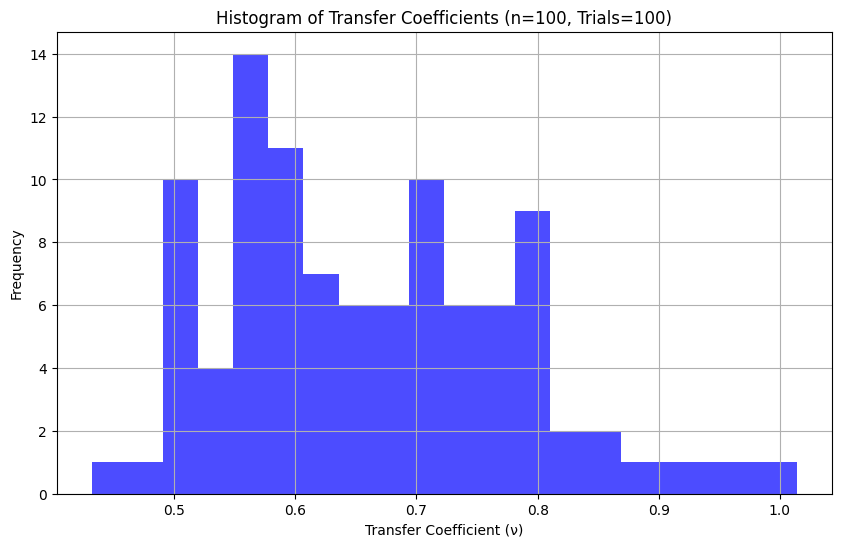

In [10]:
all_transfer_coefficients = torch.tensor(all_transfer_coefficients)

plt.figure(figsize=(10, 6))
plt.hist(all_transfer_coefficients.cpu().numpy(), bins=20, alpha=0.7, color="blue")
plt.xlabel("Transfer Coefficient (ν)")
plt.ylabel("Frequency")
plt.title(f"Histogram of Transfer Coefficients (n={n}, Trials={num_trials})")
plt.grid()
plt.show()